# Support Vector Classifier

In [5]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE

pd.set_option('display.max_columns', 500)

In [39]:
df = pd.read_csv('../data/clinical_training_data_with_medhist_famhist.csv')

# For converting categorical variables to ints
label_encoder = LabelEncoder()
scaler = MinMaxScaler()

# Split features / target
X = df.drop(columns=['AD_dx_in_5_yrs'])
y = df['AD_dx_in_5_yrs']

# Encode features
X["Diagnosis_at_Baseline"] = label_encoder.fit_transform(X["Diagnosis_at_Baseline"])
X["Gender"] = label_encoder.fit_transform(X["Gender"])
X["Ethnicity"] = label_encoder.fit_transform(X["Ethnicity"])
X["Race"] = label_encoder.fit_transform(X["Race"])

# Handle NaN
X["Family_History_of_AD"] = X["Family_History_of_AD"].fillna(0)
X["Family_History_of_Dementia"] = X["Family_History_of_Dementia"].fillna(0)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale data
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# SMOTE
smote = SMOTE(sampling_strategy="auto")
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Instantiate Model
svc = SVC()

### Grid Search

In [22]:
# Grid search
param_grid = {
    "C": [0.1, 1, 10],                
    "kernel": ["linear", "poly", "rbf", "sigmoid"],
    "gamma": ["scale", "auto", 0.1],
    "degree": [1, 2, 3, 4, 5]}

In [23]:
grid_search = GridSearchCV(estimator=svc, param_grid=param_grid, cv=5, scoring="accuracy")

In [24]:
grid_search.fit(X_resampled, y_resampled)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10], 'degree': [1, 2, 3, 4, 5],
                         'gamma': ['scale', 'auto', 0.1],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             scoring='accuracy')

In [25]:
# Get the best parameters and best accuracy score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Print the best parameters and best score
print("Best Parameters:", best_params)
print("Best Accuracy:", best_score)

Best Parameters: {'C': 1, 'degree': 4, 'gamma': 'scale', 'kernel': 'poly'}
Best Accuracy: 0.8309717974855589


### Train with Best Parameters

In [26]:
# Instantiate and fit model
svc = SVC(C=1, degree=4, gamma="scale", kernel="poly")

svc.fit(X_resampled, y_resampled)

SVC(C=1, degree=4, kernel='poly')

In [27]:
# Assess
y_pred = svc.predict(X_test)

# evaluate predictions
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.86      0.85        72
           1       0.60      0.56      0.58        27

    accuracy                           0.78        99
   macro avg       0.72      0.71      0.71        99
weighted avg       0.77      0.78      0.78        99



# Neural Network

In [28]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from imblearn.over_sampling import SMOTE

tf.config.run_functions_eagerly(True)

In [74]:
df = pd.read_csv('../data/clinical_training_data_with_medhist_famhist.csv')

# For converting categorical variables to ints
label_encoder = LabelEncoder()
scaler = MinMaxScaler()

# Split features / target
X = df.drop(columns=['AD_dx_in_5_yrs'])
y = df['AD_dx_in_5_yrs']

# Encode features
X["Diagnosis_at_Baseline"] = label_encoder.fit_transform(X["Diagnosis_at_Baseline"])
X["Gender"] = label_encoder.fit_transform(X["Gender"])
X["Ethnicity"] = label_encoder.fit_transform(X["Ethnicity"])
X["Race"] = label_encoder.fit_transform(X["Race"])

# Handle NaN
X["Family_History_of_AD"] = X["Family_History_of_AD"].fillna(0)
X["Family_History_of_Dementia"] = X["Family_History_of_Dementia"].fillna(0)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale data
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# SMOTE
smote = SMOTE(sampling_strategy="auto")
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

In [75]:
IN_FEATURES = X_train[0].shape[0]

In [76]:
def create_model(dropout=0.3, learning_rate=0.0001):
    
    """Builds classification model"""
    
    model = tf.keras.Sequential()
    inputs = tf.keras.layers.Input(shape=(IN_FEATURES,), name="input_layer") # (Batch, num_features)
    
    hidden_1 = tf.keras.layers.Dense(512, activation="relu", name="hidden_1")(inputs)
    hidden_1 = tf.keras.layers.Dropout(dropout)(hidden_1)
    hidden_2 = tf.keras.layers.Dense(256, activation="relu", name="hidden_2")(hidden_1)
    hidden_2 = tf.keras.layers.Dropout(dropout)(hidden_2)
    
    classification = tf.keras.layers.Dense(1, activation="sigmoid", name="classification_layer")(hidden_2)
    classification_model = tf.keras.Model(inputs=[inputs], outputs=[classification])
    
    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
                                 metrics="accuracy")

    return classification_model

In [77]:
model = create_model()

In [78]:
history = model.fit(X_resampled,
                    y_resampled,
                    batch_size=16,
                    epochs=20)

Epoch 1/20
 4/34 [==>...........................] - ETA: 0s - loss: 0.6900 - accuracy: 0.6094

/Users/johngalvin/miniforge3/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/Users/johngalvin/miniforge3/lib/python3.9/site-packages/keras/backend.py:5676: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


34/34 [==============================] - 1s 21ms/step - loss: 0.6960 - accuracy: 0.5294
Epoch 2/20
34/34 [==============================] - 1s 21ms/step - loss: 0.6635 - accuracy: 0.6342
Epoch 3/20
34/34 [==============================] - 1s 22ms/step - loss: 0.6265 - accuracy: 0.7298
Epoch 4/20
34/34 [==============================] - 1s 22ms/step - loss: 0.6017 - accuracy: 0.7408
Epoch 5/20
34/34 [==============================] - 1s 23ms/step - loss: 0.5671 - accuracy: 0.7684
Epoch 6/20
34/34 [==============================] - 1s 23ms/step - loss: 0.5340 - accuracy: 0.7923
Epoch 7/20
34/34 [==============================] - 1s 22ms/step - loss: 0.5083 - accuracy: 0.7941
Epoch 8/20
34/34 [==============================] - 1s 23ms/step - loss: 0.4860 - accuracy: 0.7996
Epoch 9/20
34/34 [==============================] - 1s 22ms/step - loss: 0.4654 - accuracy: 0.8125
Epoch 10/20
34/34 [==============================] - 1s 21ms/step - loss: 0.4501 - accuracy: 0.8015
Epoch 11/20
34/34 [=

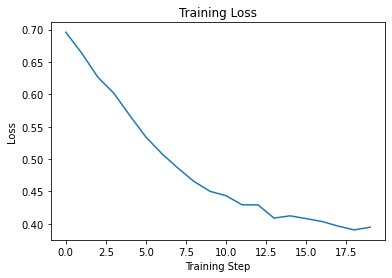

In [79]:
# Visualize loss curve

losses = history.history["loss"]
plt.plot(losses)
plt.xlabel("Training Step")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()

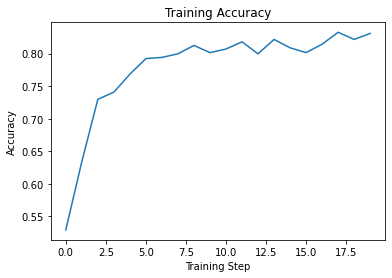

In [80]:
# Visualize accuracy curve

losses = history.history["accuracy"]
plt.plot(losses)
plt.xlabel("Training Step")
plt.ylabel("Accuracy")
plt.title("Training Accuracy")
plt.show()

In [81]:
model.evaluate(X_test, y_test)

4/4 [==============================] - 0s 9ms/step - loss: 0.4467 - accuracy: 0.7576


[0.44667932391166687, 0.7575757503509521]

In [73]:
preds = model.predict(X_test)
preds

4/4 [==============================] - 0s 5ms/step


array([[0.83025366, 0.13173184],
       [0.58554125, 0.30972934],
       [0.34647143, 0.5853814 ],
       [0.874224  , 0.07530349],
       [0.32720515, 0.65340126],
       [0.89023155, 0.07198436],
       [0.5215387 , 0.43603942],
       [0.5885729 , 0.3099296 ],
       [0.4588393 , 0.46300972],
       [0.7707359 , 0.18807888],
       [0.59988165, 0.3531658 ],
       [0.5400775 , 0.41626772],
       [0.86411464, 0.09744453],
       [0.7802302 , 0.1625373 ],
       [0.39044634, 0.6114196 ],
       [0.8723717 , 0.07677459],
       [0.4527714 , 0.5141437 ],
       [0.859606  , 0.08936518],
       [0.49396205, 0.4999123 ],
       [0.517729  , 0.47749078],
       [0.48128745, 0.49076828],
       [0.82961124, 0.12068537],
       [0.31975636, 0.7169026 ],
       [0.8579848 , 0.10239985],
       [0.875369  , 0.08542534],
       [0.87493277, 0.0879528 ],
       [0.7849036 , 0.1510566 ],
       [0.36504632, 0.56961733],
       [0.8692314 , 0.07882469],
       [0.82231504, 0.10798053],
       [0.